**ECE 447 Project B - Anomaly Detection**

Nathaniel De Jesus (1718460), Raphael Ramos (1727532)


In [6]:
# adding all the tools needed in this project first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import kagglehub
import os
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import t

In [7]:
# processing the second provided dataset

# building dataframe
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
csv_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_path)

# check dataframe for missing values
df = df.fillna(method='ffill')  # (Just in case — though this dataset has no missing values)

# scaling time, amount
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

# nomral data for training
df_norm = df[df['Class'] == 0]
df_anomalous = df[df['Class'] == 1]

# splitting into training and testing sets
train_norm, test_norm = train_test_split(df_norm, test_size=0.2, random_state=42)

# to evaluate, use  the normal test set and anomalies
df_test = pd.concat([test_norm, df_anomalous], ignore_index=True)

# separating
X_train = train_norm.drop('Class', axis=1).values
X_test = df_test.drop('Class', axis=1).values
y_test = df_test['Class'].values  # 0 = normal, 1 = anomaly

pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("PCA reduced shapes:", X_train_pca.shape, X_test_pca.shape)

# data dimensions
print("Data shape:", df.shape)

PCA reduced shapes: (227452, 10) (57355, 10)
Data shape: (284807, 31)


In [8]:
def anomalies(df, amount_col='Amount', window=100, threshold=3):
    """
    flags anomalies based on moving average and standard deviation
    bands; adds an 'Anomaly' column to dataframe (1 for anomaly).
    """
    rolling_mean = df[amount_col].rolling(window=window).mean()
    rolling_std = df[amount_col].rolling(window=window).std()

    upper_bound = rolling_mean + threshold * rolling_std
    lower_bound = rolling_mean - threshold * rolling_std

    df['Anomaly'] = ((df[amount_col] > upper_bound) | (df[amount_col] < lower_bound)).astype(int)
    return df

def grubbs(val, alpha=0.05):
    """
    uses grubbs' test to find outliers by tracking their indices;
    tracks outlier indices in val, returns as an array of 0 and 1
    """
    val = np.array(val)
    indices = np.arange(len(val))
    outliers = []

    while len(val) > 2:
        abs_deviation = np.abs(val - np.mean(val))
        max_dev_idx = np.argmax(abs_deviation)

        G = abs_deviation[max_dev_idx] / np.std(val)
        N = len(val)

        t_crit = t.ppf(1 - alpha / (2 * N), N - 2)
        G_crit = ((N - 1) / np.sqrt(N)) * np.sqrt(t_crit**2 / (N - 2 + t_crit**2))

        if G > G_crit:
            outliers.append(indices[max_dev_idx])
            val = np.delete(val, max_dev_idx)
            indices = np.delete(indices, max_dev_idx)

        else:
            break

    return outliers

df = anomalies(df)
df['Grubbs'] = 0
df.loc[grubbs(df['Amount']), 'Grubbs'] = 1



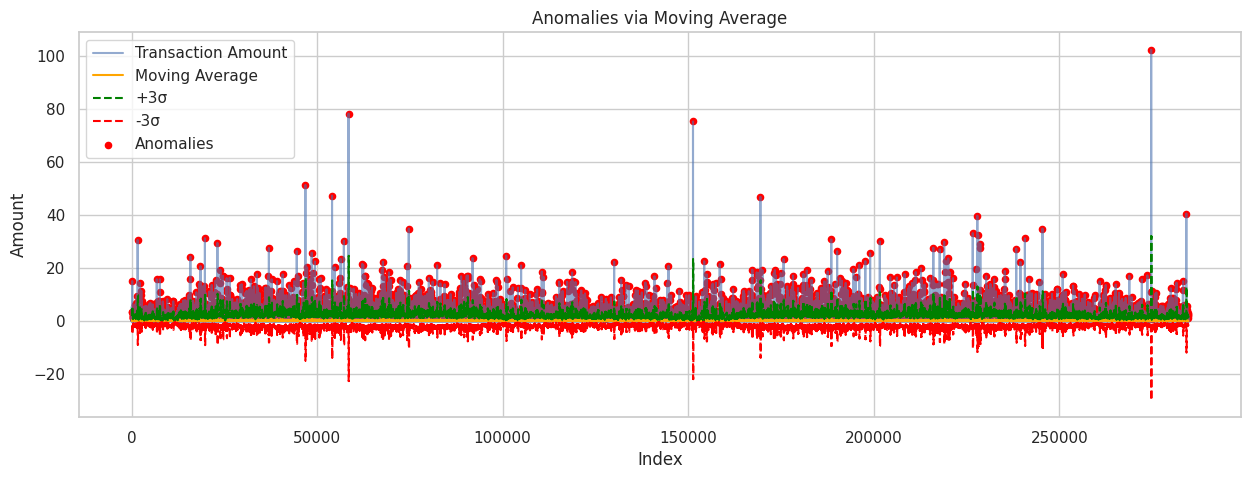

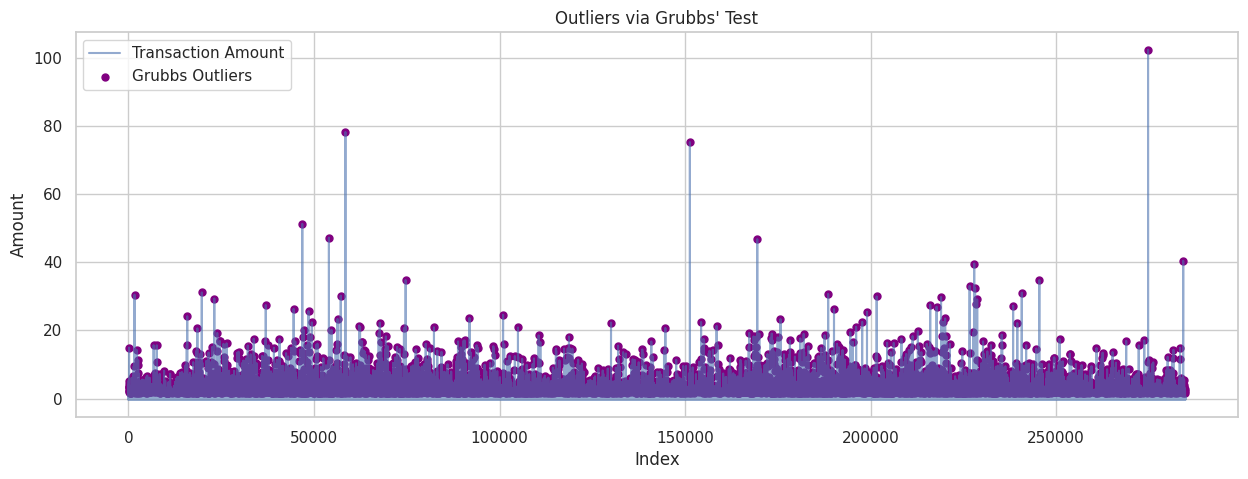

In [9]:
def plot_anomalies(df, amount_col='Amount', label_col='Anomaly', window=100, threshold=3):
    """
    plots transaction amounts with moving average bands, highlights anomalies.
    """
    rolling_mean = df[amount_col].rolling(window=window).mean()
    rolling_std = df[amount_col].rolling(window=window).std()

    upper_bound = rolling_mean + threshold * rolling_std
    lower_bound = rolling_mean - threshold * rolling_std

    plt.figure(figsize=(15, 5))
    plt.plot(df[amount_col].values, label='Transaction Amount', alpha=0.6)
    plt.plot(rolling_mean, color='orange', label='Moving Average')
    plt.plot(upper_bound, color='green', linestyle='--', label='+3σ')
    plt.plot(lower_bound, color='red', linestyle='--', label='-3σ')
    plt.scatter(df.index[df[label_col] == 1], df.loc[df[label_col] == 1, amount_col],
                color='red', label='Anomalies', s=20)

    plt.legend()
    plt.title("Anomalies via Moving Average")
    plt.xlabel("Index")
    plt.ylabel("Amount")
    plt.show()


def plot_grubbs(df, amount_col='Amount', label_col='Grubbs'):
    """
    plots data with grubbs' outliers.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(df[amount_col].values, label='Transaction Amount', alpha=0.6)
    plt.scatter(df.index[df[label_col] == 1], df.loc[df[label_col] == 1, amount_col],
                color='purple', label='Grubbs Outliers', s=25)
    plt.legend()
    plt.title("Outliers via Grubbs' Test")
    plt.xlabel("Index")
    plt.ylabel("Amount")
    plt.show()

plot_anomalies(df)
plot_grubbs(df)



In [10]:
#kNN
def knn_anomaly_scores_chunked(X_train, X_test, k=10, batch_size=5000):
    nn = NearestNeighbors(n_neighbors=k,
                          metric="manhattan",
                          n_jobs=-1)
    nn.fit(X_train)
    scores = np.empty(X_test.shape[0], dtype=float)
    for start in range(0, X_test.shape[0], batch_size):
        end = min(start + batch_size, X_test.shape[0])
        dist, _ = nn.kneighbors(X_test[start:end])
        scores[start:end] = dist.mean(axis=1)
    return scores

# Compute k-NN scores & binary predictions
scores_knn = knn_anomaly_scores_chunked(
    X_train_pca, X_test_pca,
    k=10, batch_size=5000
)
y_pred_knn = (scores_knn > np.percentile(scores_knn, 99.7)).astype(int)

# Quick metrics
from sklearn.metrics import precision_score, recall_score, f1_score
print("kNN →",
      f"precision={precision_score(y_test, y_pred_knn):.3f},",
      f"recall={recall_score(y_test, y_pred_knn):.3f},",
      f"F1={f1_score(y_test, y_pred_knn):.3f}")

kNN → precision=0.393, recall=0.138, F1=0.205


In [11]:
dbscan = DBSCAN(
    eps=1.5,           # tune via k-distance plot if needed
    min_samples=10,
    metric='euclidean',
    n_jobs=-1
)
labels_dbscan = dbscan.fit_predict(X_test_pca)
y_pred_dbscan = (labels_dbscan == -1).astype(int)

# Evaluate
print("DBSCAN →",
      f"precision={precision_score(y_test, y_pred_dbscan):.3f},",
      f"recall={recall_score(y_test, y_pred_dbscan):.3f},",
      f"F1={f1_score(y_test, y_pred_dbscan):.3f}")

DBSCAN → precision=0.050, recall=0.722, F1=0.094


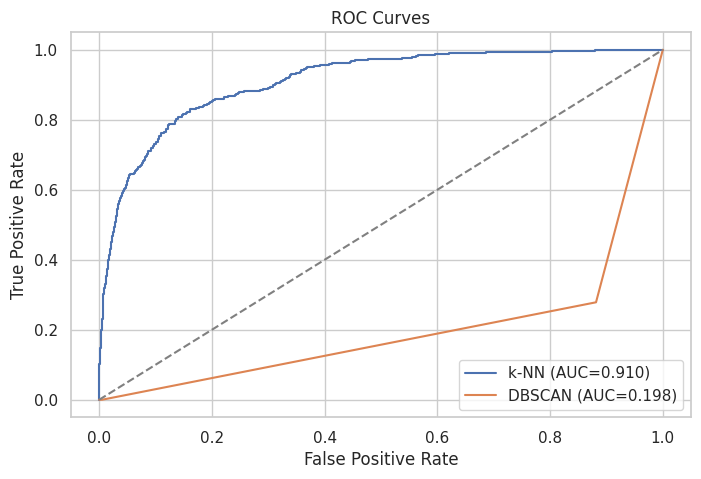

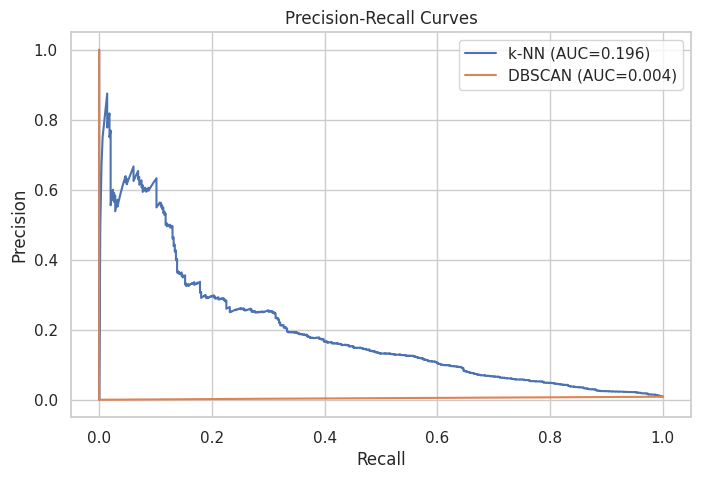

In [12]:
methods = {
    'k-NN': (scores_knn, y_pred_knn),
    'DBSCAN': (scores_knn*0 + 1.0*labels_dbscan, y_pred_dbscan)
    # Note: we need anomaly *scores*, so we reuse `scores_knn*0+...` hack
}

# ROC
plt.figure(figsize=(8, 5))
for name, (scores_arr, _) in methods.items():
    fpr, tpr, _ = roc_curve(y_test, scores_arr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# PR
plt.figure(figsize=(8, 5))
for name, (scores_arr, _) in methods.items():
    prec, rec, _ = precision_recall_curve(y_test, scores_arr)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f'{name} (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

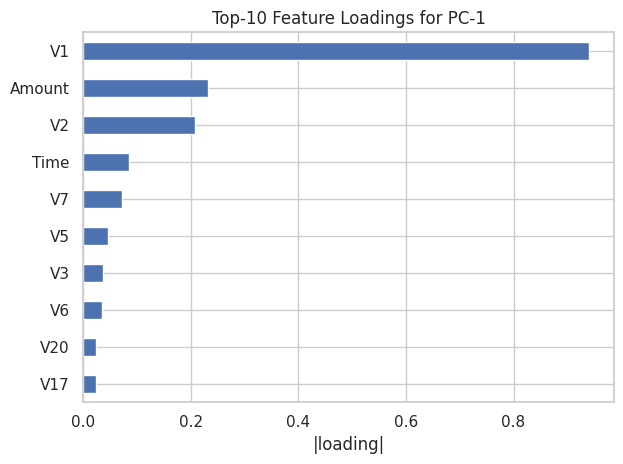

In [13]:
feature_names = df.drop('Class', axis=1).columns
loading_scores = np.abs(pca.components_[0])
top_idx = loading_scores.argsort()[-10:]

pd.Series(loading_scores[top_idx], index=feature_names[top_idx])\
  .sort_values().plot(kind='barh')
plt.title('Top-10 Feature Loadings for PC-1')
plt.xlabel('|loading|')
plt.tight_layout()
plt.show()